## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-10}~\varepsilon / k_B$;
   - Скорость охлаждения: $v_T = 0.001~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2500$ шагов;
   - Число ансамблей $N=1000$;
   - Подсчёт состоял из $2N+499$ шагов: $500$ на уравновешивание системы при фиксированной температуре и $2N-1$ на усреднение по ансамблям (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.postprocessing import PostProcessor, RegressionRDF

#### Настройки рисунков

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.size'] = 14

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)

#### Путь к файлам с данными

In [3]:
CURRENT_DATA = '2021-04-21_cooling_slow_1.0'
PLOT_FILENAME_POSTFIX = 'slow_cooling'

In [4]:
PATH_TO_CURRENT_DATA = os.path.join(con.PATH_TO_DATA, CURRENT_DATA)
PATH_TO_CURRENT_DATA

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-04-21_cooling_slow_1.0'

In [5]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA)
PATH_TO_CURRENT_PLOTS

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\plots\\2021-04-21_cooling_slow_1.0'

#### Пользовательские функции

In [6]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры системы, при которых были подчитаны функции радиального распределения, среднеквадратичные смещения и т.д.

In [8]:
setups = []
for filename in os.listdir(PATH_TO_CURRENT_DATA):
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
            
        }
        setups.append(setup)
        
setups

[{'temperature': 0.95027, 'pressure': 0.67973, 'heating_velocity': 0.001},
 {'temperature': 0.95304, 'pressure': 0.71034, 'heating_velocity': 0.001},
 {'temperature': 0.96296, 'pressure': 0.80055, 'heating_velocity': 0.001},
 {'temperature': 0.9659, 'pressure': 0.75308, 'heating_velocity': 0.001},
 {'temperature': 0.97099, 'pressure': 0.8081, 'heating_velocity': 0.001},
 {'temperature': 0.97571, 'pressure': 0.80615, 'heating_velocity': 0.001},
 {'temperature': 0.97834, 'pressure': 0.77038, 'heating_velocity': 0.001},
 {'temperature': 0.98447, 'pressure': 0.84615, 'heating_velocity': 0.001},
 {'temperature': 0.99088, 'pressure': 0.88849, 'heating_velocity': 0.001},
 {'temperature': 0.99563, 'pressure': 0.90732, 'heating_velocity': 0.001},
 {'temperature': 0.99962, 'pressure': -2.18977, 'heating_velocity': 0.001}]

#### Температуры, для которых функция радиального распределения предсказывается

In [9]:
test_temperatures = (0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-4)

#### Инициализация объекта для обработки данных и вывод таблицы значений функции радиального распределения

In [10]:
pp = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX, 
    setups=setups,
)
pp.rdf.data

,radius,setup_0,setup_1,setup_2,setup_3,setup_4,setup_5,setup_6,setup_7,setup_8,setup_9,setup_10
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
607,6.08,1.002606,1.001630,1.003233,1.003143,1.003024,1.002217,1.001433,0.999840,1.002394,1.005055,1.000569
608,6.09,1.002880,1.002031,1.001846,1.004007,1.001616,1.004061,1.000646,0.999492,1.003235,1.006074,1.000721
609,6.10,1.003894,1.001727,1.003506,1.001958,1.002662,1.001507,0.998775,1.000152,1.002570,1.003769,0.999524
610,6.11,1.004449,1.001232,1.002985,1.002873,1.004225,1.001453,1.000336,1.000065,1.003652,1.003240,1.000953


#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

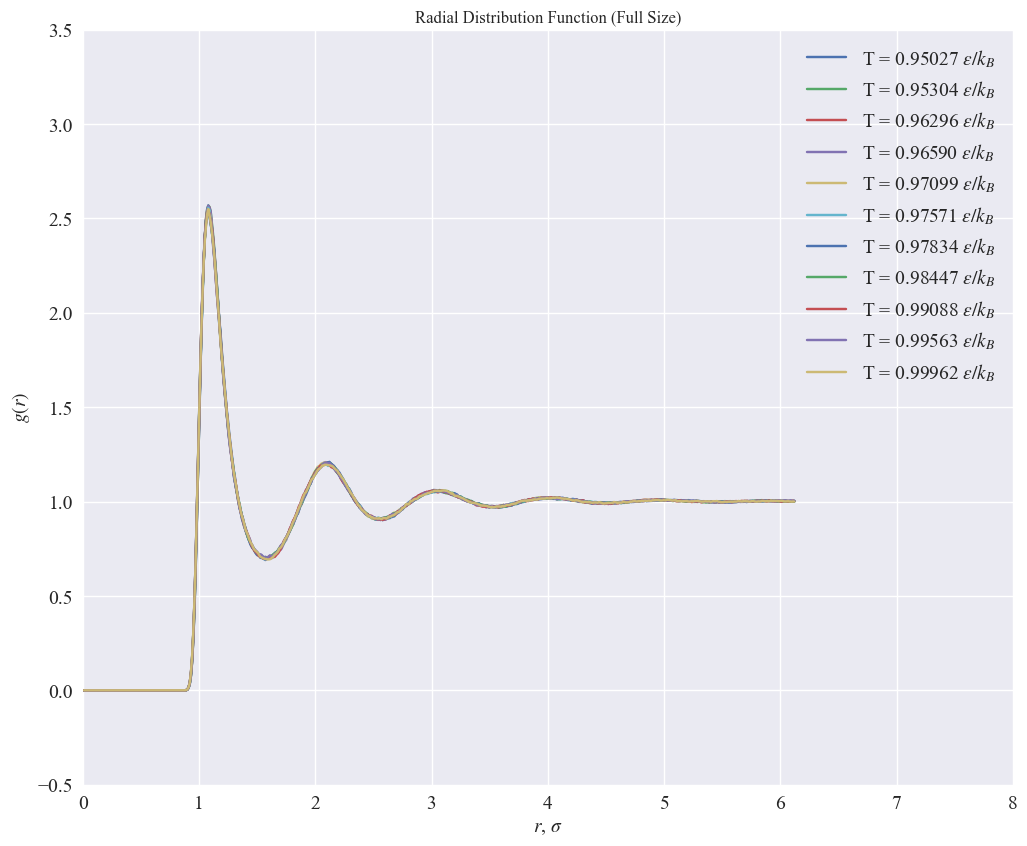

In [11]:
pp.plot_rdf(
    shift=0.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=3.5,
    figsize=(12, 10),
    title='Radial Distribution Function (Full Size)',
    filename_postfix='full_size',
)

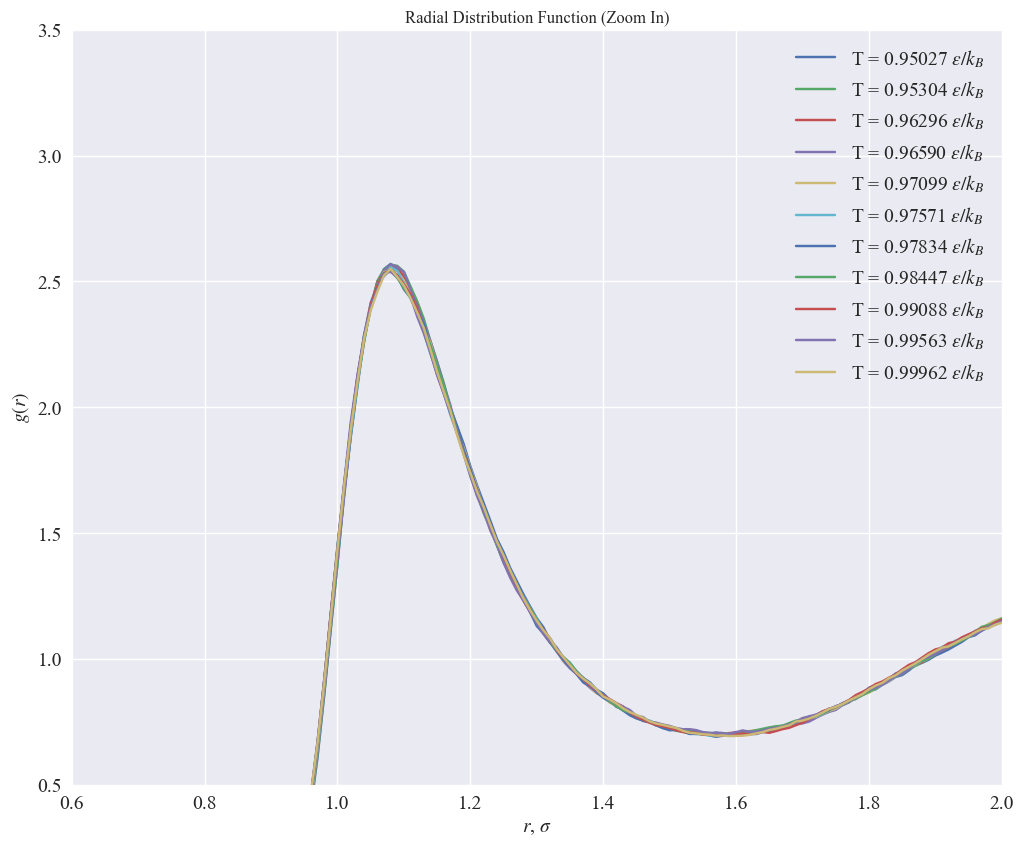

In [12]:
pp.plot_rdf(
    shift=0.0,
    left=0.6, 
    right=2,
    bottom=0.5,
    top=3.5, 
    figsize=(12, 10),
    title='Radial Distribution Function (Zoom In)',
    filename_postfix='zoom_in',
)

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [13]:
rr = RegressionRDF(
    post_processor=pp, 
    setups=setups,
    test_temperatures=test_temperatures,
)
rdf_table = rr.get_rdf_table()
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
setup_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.001781,1.000984,1.001576,1.001583,1.001951,1.000569,1.000721,0.999524,1.000953,0.999957
setup_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005182,1.004178,1.004097,1.003874,1.003713,1.005055,1.006074,1.003769,1.003240,1.003800
setup_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003792,1.002377,1.003018,1.000532,1.001114,1.002394,1.003235,1.002570,1.003652,1.002757
setup_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.001051,1.000891,1.000840,1.001035,1.000225,0.999840,0.999492,1.000152,1.000065,1.000468
setup_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002342,1.003657,1.003081,1.002441,1.002066,1.001433,1.000646,0.998775,1.000336,1.000319
setup_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004205,1.003253,1.002507,1.002077,1.001783,1.002217,1.004061,1.001507,1.001453,1.001274
setup_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004099,1.001386,1.001913,1.004745,1.003233,1.003024,1.001616,1.002662,1.004225,1.001794
setup_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004818,1.004857,1.005492,1.004098,1.004109,1.003143,1.004007,1.001958,1.002873,1.002642
setup_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002863,1.002968,1.003709,1.002351,1.001962,1.003233,1.001846,1.003506,1.002985,1.001528
setup_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003584,1.003991,1.002680,1.000389,1.003254,1.001630,1.002031,1.001727,1.001232,1.003043


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм линейной регрессии. То есть будем искать функции вида $g_i = k_iT + b_i$ Ниже показаны значения расстояния между частицами $r_i$, соответствующие значения коэффициентов $k_i, b_i$ и значения среднеквадратичной ошибки RMSE

In [14]:
predicted_points = rr.run_linear_regressions(
    is_printed=True,
    is_plotted=False,
)

r = 0.86; k =  0.00006; b = -0.00004; RMSE = 0.00003
r = 0.87; k =  0.00006; b = -0.00000; RMSE = 0.00004
r = 0.88; k = -0.00109; b =  0.00133; RMSE = 0.00010
r = 0.89; k =  0.00004; b =  0.00122; RMSE = 0.00022
r = 0.90; k =  0.02119; b = -0.01589; RMSE = 0.00040
r = 0.91; k =  0.06553; b = -0.04907; RMSE = 0.00081
r = 0.92; k =  0.17912; b = -0.13757; RMSE = 0.00135
r = 0.93; k =  0.37199; b = -0.28034; RMSE = 0.00105
r = 0.94; k =  0.52669; b = -0.35384; RMSE = 0.00349
r = 0.95; k =  0.74316; b = -0.44455; RMSE = 0.00498
r = 0.96; k =  1.07515; b = -0.60590; RMSE = 0.00450
r = 0.97; k =  1.17575; b = -0.49652; RMSE = 0.00753
r = 0.98; k =  1.24616; b = -0.32264; RMSE = 0.00933
r = 0.99; k =  1.26382; b = -0.07439; RMSE = 0.01148
r = 1.00; k =  1.35742; b =  0.09806; RMSE = 0.01124
r = 1.01; k =  0.79837; b =  0.89869; RMSE = 0.01070
r = 1.02; k =  0.75736; b =  1.17176; RMSE = 0.01113
r = 1.03; k =  0.39502; b =  1.72180; RMSE = 0.01045
r = 1.04; k =  0.21894; b =  2.06056; RMSE = 0

r = 3.16; k = -0.00695; b =  1.04988; RMSE = 0.00247
r = 3.17; k = -0.07698; b =  1.11557; RMSE = 0.00263
r = 3.18; k = -0.06156; b =  1.09936; RMSE = 0.00340
r = 3.19; k = -0.11171; b =  1.14577; RMSE = 0.00268
r = 3.20; k = -0.10029; b =  1.13196; RMSE = 0.00361
r = 3.21; k = -0.06733; b =  1.09731; RMSE = 0.00324
r = 3.22; k = -0.08597; b =  1.11389; RMSE = 0.00312
r = 3.23; k =  0.01195; b =  1.01460; RMSE = 0.00267
r = 3.24; k = -0.02648; b =  1.04912; RMSE = 0.00185
r = 3.25; k = -0.11363; b =  1.13215; RMSE = 0.00262
r = 3.26; k = -0.05886; b =  1.07559; RMSE = 0.00260
r = 3.27; k = -0.06140; b =  1.07418; RMSE = 0.00327
r = 3.28; k = -0.05276; b =  1.06359; RMSE = 0.00221
r = 3.29; k = -0.08628; b =  1.09321; RMSE = 0.00222
r = 3.30; k = -0.10272; b =  1.10686; RMSE = 0.00227
r = 3.31; k = -0.12663; b =  1.12858; RMSE = 0.00270
r = 3.32; k = -0.04260; b =  1.04392; RMSE = 0.00307
r = 3.33; k = -0.01807; b =  1.01726; RMSE = 0.00201
r = 3.34; k = -0.07635; b =  1.07270; RMSE = 0

r = 5.59; k = -0.00168; b =  1.00027; RMSE = 0.00140
r = 5.60; k =  0.02847; b =  0.97156; RMSE = 0.00142
r = 5.61; k =  0.01417; b =  0.98593; RMSE = 0.00162
r = 5.62; k =  0.01362; b =  0.98621; RMSE = 0.00156
r = 5.63; k =  0.01014; b =  0.99044; RMSE = 0.00120
r = 5.64; k =  0.03242; b =  0.96888; RMSE = 0.00114
r = 5.65; k = -0.00375; b =  1.00403; RMSE = 0.00081
r = 5.66; k = -0.01596; b =  1.01607; RMSE = 0.00151
r = 5.67; k =  0.02336; b =  0.97811; RMSE = 0.00153
r = 5.68; k =  0.04942; b =  0.95285; RMSE = 0.00109
r = 5.69; k =  0.03416; b =  0.96790; RMSE = 0.00151
r = 5.70; k =  0.03316; b =  0.96910; RMSE = 0.00130
r = 5.71; k =  0.03762; b =  0.96486; RMSE = 0.00139
r = 5.72; k =  0.01752; b =  0.98464; RMSE = 0.00126
r = 5.73; k =  0.00075; b =  1.00056; RMSE = 0.00089
r = 5.74; k = -0.00983; b =  1.01171; RMSE = 0.00115
r = 5.75; k = -0.02157; b =  1.02295; RMSE = 0.00077
r = 5.76; k = -0.00673; b =  1.00930; RMSE = 0.00136
r = 5.77; k = -0.00416; b =  1.00621; RMSE = 0

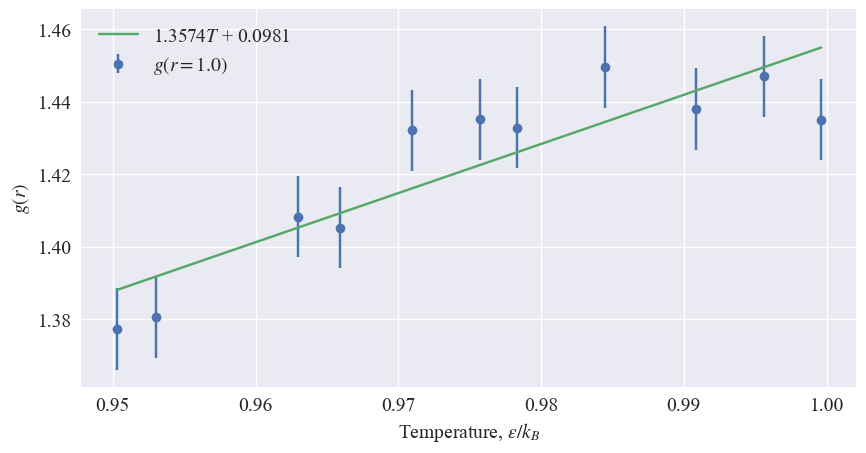

In [15]:
for column in (1.0, ):
    y = rr.rdf_table[column]
    k, b, fitted_data, error = rr.get_fitted_column(y_train=y)
    rr.plot_linear_regression(
        y_train=y,
        fitted_data=fitted_data,
        error=error,
        k=k, b=b, r=column,
        is_saved=True,
    )
    plt.close()

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах (direct - посчитанные напрямую, predicted - предсказанные)

NameError: name 'temperatures' is not defined

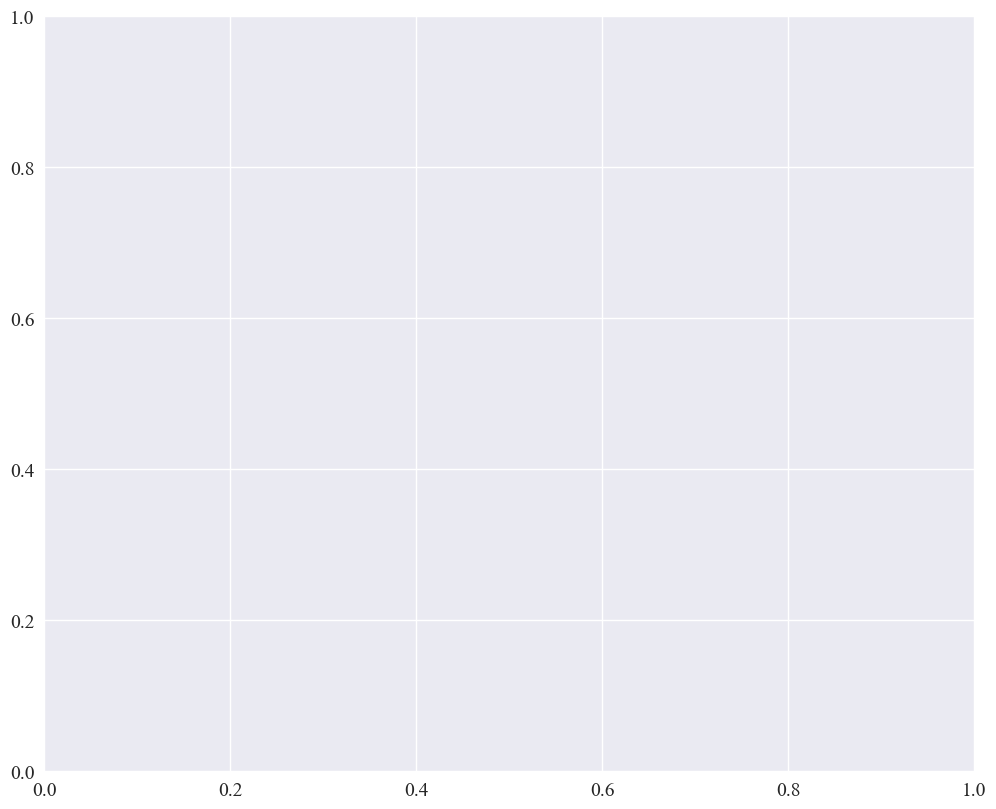

In [16]:
for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate((temperatures[0], temperatures[-1])):
    current_rdf = rdf_data[f'{temperature:.5f}']
    ax.plot(
        rdf_data['radius'],
        current_rdf,
        label=fr'$T$ = {temperature:.1f} $\epsilon / k_B $(direct)',
        color=COLORS[i],
    );

for key, value in predicted_points.items():
    for i, r in enumerate(rdf_points.columns.values):
        if value[i] < 0:
            print(r, value[i])
    print()
    ax.plot(rdf_points.columns.values, value, label=fr'$T$ = {key} $\epsilon / k_B $(predicted)');
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-0.5, 
    top=3.5,
);
ax.set_title('Radial Distribution Function (Full Size)')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_{PLOT_FILENAME_POSTFIX}.png')

In [ ]:
for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate((temperatures[0], temperatures[-1])):
    current_rdf = rdf_data[f'{temperature:.5f}']
    ax.plot(
        rdf_data['radius'],
        rdf_data[f'{temperature:.5f}'],
        label=fr'$T$ = {temperature:.1f} $\epsilon / k_B $(direct)',
        color=COLORS[i],
    );

for key, value in predicted_points.items():
    ax.plot(rdf_points.columns.values, value, label=fr'$T$ = {key} $\epsilon / k_B $(predicted)');
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0.6, 
    right=2,
);
ax.set_ylim(
    bottom=0.5,
    top=3.5, 
);
ax.set_title('Radial Distribution Function (Zoom In)')
ax.legend();

save_plot(f'rdf_with_predicted_zoom_in_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость среднеквадратичного смещения $\left<\Delta r^2(t)\right>$ при различных температурах

$$\left<\Delta r^2(t)\right>=\dfrac{1}{N}\sum_{i=1}^{N}{\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2}$$

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
for i, temperature in enumerate(temperatures):
    ax.plot(
        msd_data['time'],
        msd_data[f'{temperature:.5f}'], 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel(r'$t$, $\tau $');
ax.set_ylabel(r'$\left<\Delta r^2(t)\right>$, $\sigma^2$');
ax.set_xlim(
    left=0, 
    right=7,
);
ax.set_ylim(
    bottom=0, 
    top=3,
);
ax.set_title('Mean Squared Displacement');
ax.legend();

save_plot(f'msd_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость автокорреляционнной функции скорости $\Psi(t)$ при различных температурах

$$\Psi(t) = \dfrac{1}{N}\left<\sum_{j=1}^N{\vec{v}_j(t)\vec{v}_j(0)}\right>$$

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate(temperatures):
    ax.plot(
        vaf_data['time'],
        vaf_data[f'{temperature:.5f}'], 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel(r'$t$, $\tau $');
ax.set_ylabel(r'$\Psi(t)$, $\sigma^2$');
ax.set_xlim(
    left=0, 
    right=1,
);
ax.set_ylim(
    bottom=-0.5, 
    top=3,
);
ax.set_title('Velocity autocorrelation function')
ax.legend();

save_plot(f'vaf_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Эйнштейна, при различных температурах

$$D_E(t)=\dfrac{\left<\left<\Delta r^2\right>\right>}{6t}=\dfrac{1}{6tN}\left<\sum_{i=1}^{N}\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2\right>$$

$$D=\lim_{t\rightarrow\infty}{D_E(t)}$$

In [ ]:
einstein_diffusion = np.zeros(len(temperatures), dtype=np.float64)
gk_diffusion = np.zeros(len(temperatures), dtype=np.float64)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate(temperatures):
    diff_data = einstein_diffusion_data[f'{temperature:.5f}'].values
    ax.plot(
        einstein_diffusion_data['time'].values,
        diff_data, 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    einstein_diffusion[i] = diff_data[-1]
    
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'$D_E(t)$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0, 
    right=7,
);
ax.set_ylim(
    bottom=0, 
    top=0.10,
);
ax.set_title('Einstein relation for self-diffusion')
ax.legend();

save_plot(f'diffusion_einstein_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Грина-Кубо, при различных температурах

$$D_{GK}(t)=\dfrac{1}{3}\int_{0}^{t}{\Psi(\tau)d\tau}=\dfrac{1}{3N}\int_{0}^{t}{\left<\sum_{j=1}^N{\vec{v}_j(\tau)\vec{v}_j(0)}\right>d\tau}$$

$$D=\lim_{t\rightarrow\infty}{D_{GK}(t)}$$

#### Сравнение коэффициентов самодиффузии, вычисленных через соотношения Эйнштейна и Грина-Кубо

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(
    temperatures,
    einstein_diffusion, 
    label='Einstein relation',
);
ax.set_xlabel(r'$T$, $\epsilon / k_B $');
ax.set_ylabel(r'$D$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0.8, 
    right=1,
);
ax.set_ylim(
    bottom=0.05, 
    top=0.10,
);
ax.set_title('Self-diffusion coefficients')
ax.legend(markerscale=1);

save_plot(f'diffusion_comparing_{PLOT_FILENAME_POSTFIX}.png')

In [ ]:
predicted_points = {key: [] for key in test_temperatures}

test_temperatures = np.array(test_temperatures)
x = np.array(temperatures, dtype=np.float32)
y = einstein_diffusion
regressor = LinearRegression()
regressor.fit(x.reshape((x.size, 1)), y)
k = regressor.coef_[0]
b = regressor.intercept_
training_data = k * x + b
rmse = mean_squared_error(y, training_data, squared=False)

for key, _ in predicted_points.items():
    predicted_points[key].append(k * key + b)
print(f'k = {k:5.3f}; b = {b:5.3f}; RMSE = {rmse:.3f}')

fig, ax = plt.subplots(figsize=(12, 10));
ax.set_title(f"Self-diffusion coefficients (Einstein relation)");
ax.errorbar(x, y, yerr=rmse, fmt='o', label='Calculated data');
ax.scatter(test_temperatures, k * test_temperatures + b, label='Predicted data', color='green');
x = np.linspace(0, x.max(), 10)
ax.plot(x, k * x + b, label=fr'$D(T) = {k:.3f}T {"+" if b >= 0 else "-"} {abs(b):.3f}; (RMSE = {rmse:.3f})$');
ax.set_xlabel(r'$T$, $\epsilon / k_B $');
ax.set_ylabel(r'$D$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0, 
    right=1,
);
ax.set_ylim(
    bottom=0, 
    top=0.10,
);
ax.legend(markerscale=1);
save_plot(f"diffusion_einstein_fitted_{PLOT_FILENAME_POSTFIX}.png")
plt.show();

#### Извлечение параметров системы из файла

In [ ]:
system_parameters = pd.read_csv(PARAMETERS_FILENAME, sep=';')

for column in system_parameters.columns:
    system_parameters[column] = system_parameters[column].round(5)

system_parameters

In [ ]:
times = (system_parameters.index + 1) * 0.005

#### Зависимость температуры системы от времени

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10));
ax.scatter(
    times,
    system_parameters['temperature'],
    s=1,
);
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'Temperature, $\epsilon / k_B$');
ax.set_xlim(
    left=0,
    right=25,
);
ax.set_ylim(
    bottom=0.96,
    top=1.02,
);
ax.set_title(f"Time dependence of system temperature");
save_plot(f'temperature_{PLOT_FILENAME_POSTFIX}.png')

#### Зависимость давления системы от времени

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10));
ax.scatter(
    times,
    system_parameters['pressure'],
    s=1,
);
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'Pressure, $\epsilon / \sigma^3 $');

ax.set_xlim(
    left=0,
    right=25,
);
ax.set_ylim(
    bottom=0,
    top=1.5,
);
ax.set_title(f"Time dependence of system pressure");
save_plot(f'pressure_{PLOT_FILENAME_POSTFIX}.png')

#### Зависимость энергии системы от времени

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10));
ax.scatter(
    times,
    system_parameters['system_kinetic_energy'],
    s=1,
    label='Kinetic Energy',
);
ax.scatter(
    times,
    system_parameters['potential_energy'],
    s=1,
    label='Potential Energy',
);
ax.scatter(
    times,
    system_parameters['total_energy'],
    s=1,
    label='Total Energy',
);

ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'Energy, $\epsilon$');
ax.legend(markerscale=5);

ax.set_xlim(
    left=0,
    right=25,
);
ax.set_ylim(
#     bottom=-10000,
#     top=6000,
);
ax.set_title(f"Time dependence of system energy");
save_plot(f'all_energies_{PLOT_FILENAME_POSTFIX}.png')